In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
import keras_tuner as kt
from kerastuner import HyperParameters
import os
import matplotlib.pyplot as plt
import pickle

2024-05-18 09:00:00.299818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 09:00:01.220890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_82356/1648194996.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [2]:
df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

/tmp/ipykernel_82356/2588014987.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
/tmp/ipykernel_82356/2588014987.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('processed_data.csv', infer_datetime_format=True, header = 0, parse_dates={'datetime':[0,1]}, index_col=['datetime'])


,co_gt,s1_co,c6h6_gt,s2_nhmc,nox_gt,s3_nox,no2_gt,s4_no2,s5_o3,temp,rh,ah
datetime,,,,,,,,,,,,
10/03/2004 18:00:00,0.396825,0.639299,0.356923,0.527016,0.191142,0.568345,0.445783,0.578780,0.504261,0.333333,0.489,0.280066
10/03/2004 19:00:00,0.301587,0.576568,0.280000,0.451372,0.117716,0.662670,0.361446,0.508223,0.355890,0.326882,0.477,0.264282
10/03/2004 20:00:00,0.333333,0.678044,0.267692,0.438071,0.150350,0.635492,0.449799,0.506101,0.407018,0.296774,0.540,0.276352
10/03/2004 21:00:00,0.333333,0.654059,0.273846,0.445553,0.198135,0.597122,0.481928,0.521485,0.471679,0.277419,0.600,0.294190
10/03/2004 22:00:00,0.238095,0.558118,0.190769,0.352452,0.150350,0.687450,0.457831,0.471618,0.425063,0.281720,0.596,0.295216


In [3]:
N_FEATURES = len(df.columns)
FEATURES_TO_SCALE = [f for f in df.columns if f != 'rh']

In [4]:
N_FEATURES

12

In [5]:
df.columns

Index(['co_gt', 's1_co', 'c6h6_gt', 's2_nhmc', 'nox_gt', 's3_nox', 'no2_gt',
       's4_no2', 's5_o3', 'temp', 'rh', 'ah'],
      dtype='object')

In [6]:
split = int(df.shape[0]*0.80)
train_df, test_df = df[:split], df[split:]

In [7]:
def split_series(series):
  """
  Splits data into samples of input past observations (one day before) and output future observations (current day).
  Returns a tuple of (X, y).
  """
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + 1
    future_end = past_end + 1

    if future_end > len(series):
      break

    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [8]:
X_train, y_train = split_series(train_df.values)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], N_FEATURES))

X_test, y_test = split_series(test_df.values)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], N_FEATURES))

In [9]:
# Definition of lstm autoencoder model
def build_lstm_autoencoder_model(hp):
    encoder_inputs = tf.keras.layers.Input(shape=(1, N_FEATURES))
    encoder_l1 = tf.keras.layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    decoder_inputs = tf.keras.layers.RepeatVector(1)(encoder_outputs1[0])

    decoder_l1 = tf.keras.layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=True)(decoder_inputs, initial_state=encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(N_FEATURES))(decoder_l1)

    model = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='mean_absolute_error')  # use MAE as loss function
    
    return model

In [10]:
tuner = kt.RandomSearch(
    build_lstm_autoencoder_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_autoencoder')

# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [11]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 00m 28s]
val_loss: 0.052083494141697884

Best val_loss So Far: 0.0519037451595068
Total elapsed time: 00h 03m 42s


ValueError: too many values to unpack (expected 2)

In [14]:
for hp, val in best_hps.values.items():
    print(f"best {hp}: {val}")

best units: 200
best learning_rate: 0.00028925868757120307


In [15]:
lstm_autoencoder= tuner.hypermodel.build(best_hps)
history = lstm_autoencoder.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2137 - val_loss: 0.0896
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0716 - val_loss: 0.0664
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0601 - val_loss: 0.0633
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0577 - val_loss: 0.0611
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0540 - val_loss: 0.0571
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0543 - val_loss: 0.0559
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0536 - val_loss: 0.0548
Epoch 8/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0526 - val_loss: 0.0543
Epoch 9/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0517 - val_loss: 0.0558
Epoch 10/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0531 - val_loss: 0.0540
Epoch 11/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0525 - val_loss: 0.0527
Epoch 12/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

In [16]:
def plot_loss(training_history):
    # Extract the loss values for each epoch
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

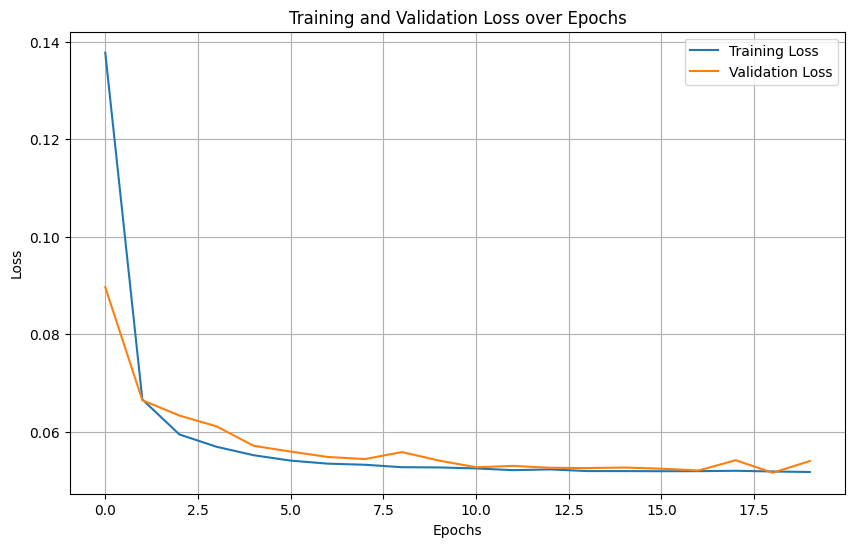

In [17]:
plot_loss(history)

In [18]:
y_test.shape

(1784, 1, 12)

In [19]:
y_pred = lstm_autoencoder.predict(X_test)

# Calculate MAE
test_mae = mean_absolute_error(y_test.reshape((y_test.shape[0], y_test.shape[2])), y_pred.reshape((y_pred.shape[0], y_pred.shape[2])))

print(f'MAE: {test_mae}')

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.05395504115324834


In [20]:
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

/opt/conda/envs/ds_env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
# Test predictions with an array from the original scale
input_vals = np.array([0.5,921,1.9,575,95,956,58,1143,672,13.7,67.8,1.0575])
input_vals = input_vals.reshape(1, -1)
rh = input_vals[:, 10].reshape(-1, 1) 
input_vals = scaler.transform(input_vals[:, [i for i in range(input_vals.shape[1]) if i != 10]])
input_vals = np.insert(input_vals, 10, rh/100, axis=1)
print(input_vals)

input_arr = input_vals.reshape((1, 1, 12))

y_pred = lstm_autoencoder.predict(input_arr)
y_pred

[[0.06349206 0.23431734 0.04923077 0.1354946  0.10839161 0.48840927
  0.2248996  0.28753316 0.20551378 0.33548387 0.678      0.42652592]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/opt/conda/envs/ds_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[[0.09712005, 0.25990155, 0.08271775, 0.20171157, 0.12976825,
         0.46165904, 0.23878837, 0.30499503, 0.23073597, 0.32350758,
         0.6866172 , 0.42595157]]], dtype=float32)

In [22]:
y_pred = y_pred.reshape(-1, N_FEATURES)
# scale features except rh
input_to_invert = y_pred[:, [i for i in range(y_pred.shape[1]) if i != 10]]
print(input_to_invert.shape)
outputs = scaler.inverse_transform(input_to_invert)
print(outputs)
outputs = np.insert(outputs, 10, y_pred[:, 10], axis=1)

for feature, val in zip(df.columns, outputs.reshape(N_FEATURES)):
    print(f"{feature}: {val}")

(1, 11)
[[7.1185631e-01 9.4873334e+02 2.9883268e+00 6.5465900e+02 1.1334116e+02
  9.2253546e+02 6.1458302e+01 1.1759156e+03 7.2231830e+02 1.3143103e+01
  1.0563247e+00]]
co_gt: 0.7118563055992126
s1_co: 948.7333374023438
c6h6_gt: 2.9883267879486084
s2_nhmc: 654.6589965820312
nox_gt: 113.3411636352539
s3_nox: 922.5354614257812
no2_gt: 61.45830154418945
s4_no2: 1175.9156494140625
s5_o3: 722.3182983398438
temp: 13.143102645874023
rh: 0.6866171956062317
ah: 1.0563247203826904
